# Convert effective radiative forcings from RCMIP model output (csv/xlsx) to xarray Dataset:

## Data availability:

Input data is available on [https://gitlab.com/rcmip/rcmip](https://gitlab.com/rcmip/rcmip).

Please contact: Zebedee Nicholls, email: zebedee.nicholls@climate-energy-college.org

## Imports:

In [1]:
import xarray as xr
from IPython.display import clear_output
import numpy as np
import os
import re
from pathlib import Path
import pandas as pd
import tqdm
from scmdata import df_append, ScmDataFrame


%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from ar6_ch6_rcmipfigs.constants import BASE_DIR
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, INPUT_DATA_DIR

SAVEPATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in


In [3]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

## ERF:
Read ERF from file

### Define variables to look at:

In [4]:
# variables to load:
variables_erf = [
    'Effective Radiative Forcing|Anthropogenic|*',
    'Effective Radiative Forcing|Anthropogenic',
    'Effective Radiative Forcing',
    'Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Deposition of Black Carbon on Snow'
]
# variables to plot:
variables_erf_comp = [
    'Effective Radiative Forcing|Anthropogenic|CH4',
    'Effective Radiative Forcing|Anthropogenic|Aerosols',
    'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
    'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC',
    'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['Effective Radiative Forcing|Anthropogenic',
                     'Effective Radiative Forcing']
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',
                # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']

### Models to look for

Models are chosen solely on availability of relevant  data:

In [5]:

model_of_interest = [
    #    ".*acc2.*v2-0-1.*",
    ".*rcmip-phase-1_cicero-scm.*",
    #    ".*escimo.*v2-0-1.*",
    ".*fair-1.5-default.*",
    #    ".*rcmip_phase-1_gir.*",
    #    ".*greb.*v2-0-0.*",
    #    ".*hector.*v2-0-0.*",
    #    ".*MAGICC7.1.0aX-rcmip-phase-1.*",
    ".*rcmip-phase-1_magicc7.1.0.beta*",
    #    ".*MAGICC7.1.0aX.*",
    #    ".*mce.*v2-0-1.*",
    #    ".*oscar-v3-0*v1-0-1.*",
    ".*oscarv3.0.*"
    #    ".*wasp.*v1-0-1.*",
]

Where to look for files:

In [6]:

# RESULTS_PATH = os.path.join(BASE_DIR, "data", "results", "phase-1/")
RESULTS_PATH = os.path.join(INPUT_DATA_DIR, "database-results", "phase-1")
RESULTS_PATH
# RESULTS_PATH

'/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1'

In [7]:
SCENARIO_PROTOCOL = os.path.join(INPUT_DATA_DIR, "data", "protocol", "rcmip-emissions-annual-means-v3-1-0.csv")
SCENARIO_PROTOCOL

'/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/data/protocol/rcmip-emissions-annual-means-v3-1-0.csv'

List of files:

In [8]:
results_files = list(Path(RESULTS_PATH).rglob("*.csv")) + list(Path(RESULTS_PATH).rglob("*.xlsx"))
results_files[:4]

[PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc32.csv'),
 PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-montreal-gases-halon2402.csv'),
 PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm_world_radiative-forcing-anthropogenic-montreal-gases-ccl4.csv'),
 PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-rcmip-phase-1_world_effective-radiative-forcing-anthropogenic-f-gases-hfc-hfc23.csv')]

## Make file list to load:

In [9]:
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print(len(results_files))
print(results_files)

1159
['/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-f-gases-hfc-hfc32.csv', '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-montreal-gases-halon2402.csv', '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm_world_radiative-forcing-anthropogenic-montreal-gases-ccl4.csv', '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-rcmip-phase-1_world_effective-radiative-forcing-anthropogenic-f-gases-hfc-hfc23.csv', '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_oscarv3.0_world_emissions-montreal-gases-hcfc141b-84th-quantile.csv', '/home/saramb

In [10]:
from ar6_ch6_rcmipfigs.utils.misc_func import prep_str_for_filename

variables_of_interest = variables_erf + variables_erf_comp + variables_erf_tot
relevant_files = [
    str(p)
    for p in results_files
    if any(
        [
            bool(re.match(".*{}.*".format(prep_str_for_filename(v)), str(p)))
            for v in variables_of_interest
        ]
    )
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files

Number of relevant files: 278


['/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-rcmip-phase-1_world_effective-radiative-forcing-anthropogenic-f-gases-hfc-hfc23.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_oscarv3.0_world_effective-radiative-forcing-anthropogenic-f-gases-hfc-hfc125.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_oscarv3.0_world_effective-radiative-forcing-anthropogenic-montreal-gases-cfc-cfc115.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-co2.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-c2f6.csv'

### Remove quantile files:

In [11]:
quantile='quantile'
relevant_files= [
    str(p)
    for p in relevant_files
    if quantile not in p]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files

Number of relevant files: 240


['/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-rcmip-phase-1_world_effective-radiative-forcing-anthropogenic-f-gases-hfc-hfc23.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_oscarv3.0_world_effective-radiative-forcing-anthropogenic-f-gases-hfc-hfc125.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_oscarv3.0_world_effective-radiative-forcing-anthropogenic-montreal-gases-cfc-cfc115.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-co2.csv',
 '/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_in/database-results/phase-1/rcmip-phase-1_cicero-scm_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-c2f6.csv'

### Read in all variables:

In [12]:
db = []
for rf in tqdm.tqdm_notebook(relevant_files):
    # print(rf.endswith('sf'))
    if rf.endswith(".csv"):
        loaded = ScmDataFrame(rf)
    else:
        loaded = ScmDataFrame(rf, sheet_name="your_data")
    db.append(loaded.filter(variable=variables_erf, scenario=scenarios_fl))  # variables_of_interest))
print(db)
db = df_append(db).timeseries().reset_index()
db["unit"] = db["unit"].apply(
    lambda x: x.replace("Dimensionless", "dimensionless") if isinstance(x, str) else x
)
clear_output()
db = ScmDataFrame(db)
db.head()

time                                                                                       1750-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   

time                                                                                       1751-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   

time                                                                                       1752-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   

time                                                                                       1753-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   

time                                                                                       1754-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   

time 

In [13]:
db[variable].unique()

array(['Effective Radiative Forcing',
       'Effective Radiative Forcing|Anthropogenic',
       'Effective Radiative Forcing|Anthropogenic|Aerosols',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|BC and OC|BC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|BC and OC|OC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burning',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burning|BC and OC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burning|BC and OC|BC',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Biomass Burnin

In [14]:
db[climatemodel].unique()

array(['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT',
       'MAGICC7.1.0.beta-rcmip-phase-1', 'OSCARv3.0'], dtype=object)

In [15]:
db[scenario].unique()

array(['historical', 'ssp119', 'ssp126', 'ssp245', 'ssp370',
       'ssp370-lowNTCF-aerchemmip', 'ssp585'], dtype=object)

In [16]:
db['unit'].unique()

array(['W/m^2'], dtype=object)

In [17]:
for cm in db[climatemodel].unique():
    print(cm+' has the following model:')
    print(db.filter(climatemodel=cm)['model'].unique())

Cicero-SCM has the following model:
['unspecified']
Cicero-SCM-ECS3 has the following model:
['unspecified']
FaIR-1.5-DEFAULT has the following model:
['unspecified']
MAGICC7.1.0.beta-rcmip-phase-1 has the following model:
['unspecified']
OSCARv3.0 has the following model:
['AIM' 'IMAGE' 'MESSAGE-GLOBIOM' 'REMIND-MAGPIE' 'unspecified']


In [18]:
db.filter(climatemodel='OSCARv3.0', variable='Effective Radiative Forcing|Anthropogenic', scenario=scenarios_fl).head(20)

time                                                                                                                        1850-01-01 00:00:00  \
model           scenario                  region variable                                  unit  climatemodel unit_context                        
AIM             ssp370                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
                ssp370-lowNTCF-aerchemmip World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
IMAGE           ssp119                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
                ssp126                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
MESSAGE-GLOBIOM ssp245                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
REMIND-MAGPIE   ssp585                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.060282   
unspecified     historical                World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.076964   

time                                                                                                                        1851-01-01 00:00:00  \
model           scenario                  region variable                                  unit  climatemodel unit_context                        
AIM             ssp370                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
                ssp370-lowNTCF-aerchemmip World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
IMAGE           ssp119                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
                ssp126                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
MESSAGE-GLOBIOM ssp245                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
REMIND-MAGPIE   ssp585                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.058564   
unspecified     historical                World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.081281   

time                                                                                                                        1852-01-01 00:00:00  \
model           scenario                  region variable                                  unit  climatemodel unit_context                        
AIM             ssp370                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
                ssp370-lowNTCF-aerchemmip World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
IMAGE           ssp119                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
                ssp126                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
MESSAGE-GLOBIOM ssp245                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
REMIND-MAGPIE   ssp585                    World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.056234   
unspecified     historical                World  Effective Radiative Forcing|Anthropogenic W/m^2 OSCARv3.0    not_required            -0.079519   

time                        

## Unify the units
Make sure all models have the same, correct units:

In [19]:
import ar6_ch6_rcmipfigs.utils.misc_func as misc_func  # misc_func

DATA_PROTOCOL = os.path.join(
    INPUT_DATA_DIR,
    "data",
    "submission-template",
    "rcmip-data-submission-template.xlsx",
)
protocol_variables = misc_func.get_protocol_vars(DATA_PROTOCOL)

In [20]:

protocol_scenarios = misc_func.get_protocol_scenarios(DATA_PROTOCOL)

In [21]:
from ar6_ch6_rcmipfigs.utils.misc_func import unify_units, plot_available_out

db_converted_units = unify_units(db, protocol_variables)

Failed to find unit for Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Other|Sea salts
Failed to find unit for Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Other|Secondary Organic Aerosols
Failed to find unit for Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Deposition of Black Carbon on Snow
Failed to find unit for Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Land Cover Change


In [22]:
db_converted_units.head()

time                                                                                       1750-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01722   

time                                                                                       1751-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.016014   

time                                                                                       1752-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01424   

time                                                                                       1753-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required             -0.01291   

time                                                                                       1754-01-01 00:00:00  \
model       scenario   region variable                    unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp119     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp126     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp245     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   
            ssp370     World  Effective Radiative Forcing W/m^2 Cicero-SCM   not_required            -0.011454   

time 

and for these the subcategories can be added up to the total:

Sum up subcategories of

erf_aerosols = "Effective Radiative Forcing|Anthropogenic|Aerosols"

erf_HFC = "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC"


## Aggregate and rename

In [23]:
from ar6_ch6_rcmipfigs.utils.misc_func import aggregate_variable

In [24]:
erf_aerosols = "Effective Radiative Forcing|Anthropogenic|Aerosols"
for cmod in db_converted_units[climatemodel].unique():
    db_converted_units = aggregate_variable(db_converted_units, erf_aerosols, cmod)  # "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC")


Model Cicero-SCM already has variable, returns unchanged
Model Cicero-SCM-ECS3 already has variable, returns unchanged
Model FaIR-1.5-DEFAULT already has variable, returns unchanged


Filtered ScmDataFrame is empty!


**Aggragating for model MAGICC7.1.0.beta-rcmip-phase-1:**
Group:
('not_required', 'World', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'unspecified', 'ssp119')
Aggregates:
[('unspecified', 'ssp119', 'World', 'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'not_required'), ('unspecified', 'ssp119', 'World', 'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'not_required')]
**Aggragating for model MAGICC7.1.0.beta-rcmip-phase-1:**
Group:
('not_required', 'World', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'unspecified', 'ssp126')
Aggregates:
[('unspecified', 'ssp126', 'World', 'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-cloud Interactions', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'not_required'), ('unspecified', 'ssp126', 'World', 'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions', 

In [26]:
erf_HFC = "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC"
# aggregate HFC variables
for cmod in db_converted_units[climatemodel].unique():
    db_converted_units = aggregate_variable(db_converted_units, erf_HFC, cmod)  # "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC")
# )

Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Model Cicero-SCM already has variable, returns unchanged
Model Cicero-SCM-ECS3 already has variable, returns unchanged
No variables to aggregate found in model FaIR-1.5-DEFAULT. Returns unchanged


Filtered ScmDataFrame is empty!


**Aggragating for model MAGICC7.1.0.beta-rcmip-phase-1:**
Group:
('not_required', 'World', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'unspecified', 'ssp119')
Aggregates:
[('unspecified', 'ssp119', 'World', 'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC125', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'not_required'), ('unspecified', 'ssp119', 'World', 'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC134a', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'not_required'), ('unspecified', 'ssp119', 'World', 'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC143a', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'not_required'), ('unspecified', 'ssp119', 'World', 'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC152a', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'not_required'), ('unspecified', 'ssp119', 'World', 'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC|HFC227ea', 'W/m^2', 'MAGICC7.1.0.beta-rcmip-phase-1', 'not_required'), ('unspecified', 'ssp119', 'W

In [28]:
# aggregate Aerosols:
db_converted_units.filter(
    variable=erf_HFC  # "Effective Radiative Forcing|Anthropogenic|F-Gases|HFC"
).head()

time                                                                                                              1750-01-01 00:00:00  \
model       scenario   region variable                                           unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp119     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp126     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp245     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp370     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                              1751-01-01 00:00:00  \
model       scenario   region variable                                           unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp119     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp126     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp245     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp370     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                              1752-01-01 00:00:00  \
model       scenario   region variable                                           unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp119     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp126     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp245     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp370     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                              1753-01-01 00:00:00  \
model       scenario   region variable                                           unit  climatemodel unit_context                        
unspecified historical World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp119     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp126     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp245     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   
            ssp370     World  Effective Radiative Forcing|Anthropogenic|F-Gas... W/m^2 Cicero-SCM   not_required                  0.0   

time                                                                                                              1754-01-01 00:00:00  \
model       scenario   

## Rename variable:

In [29]:
wrong_name = 'Effective Radiative Forcing|Anthropogenic|Albedo Change|Other|Deposition of Black Carbon on Snow'
right_name = 'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow'
print('Wrong name in climatemodels:')
print(db_converted_units.filter(variable=wrong_name)[climatemodel].unique())
print('Right name in climatemodels:')
print(db_converted_units.filter(variable=right_name)[climatemodel].unique())

Wrong name in climatemodels:
['OSCARv3.0']
Right name in climatemodels:
['FaIR-1.5-DEFAULT' 'MAGICC7.1.0.beta-rcmip-phase-1']


In [30]:
_db = db_converted_units.timeseries().reset_index()
_db[variable] = _db[variable].apply(lambda x: right_name if x == wrong_name else x)
_db=ScmDataFrame(_db)
db_converted_units = _db
print('Wrong name in climatemodels:')
print(db_converted_units.filter(variable=wrong_name)[climatemodel].unique())
print('Right name in climatemodels:')
print(db_converted_units.filter(variable=right_name)[climatemodel].unique())

Filtered ScmDataFrame is empty!


Wrong name in climatemodels:
[]
Right name in climatemodels:
['OSCARv3.0' 'FaIR-1.5-DEFAULT' 'MAGICC7.1.0.beta-rcmip-phase-1']


In [38]:
db_converted_units['model'].unique()

array([''], dtype=object)

In [39]:
# Don't need this information:
db_converted_units['model'] = ''
db_converted_units['model'].unique()

array([''], dtype=object)

## Available input overview

The plot below shows which models we have data for:

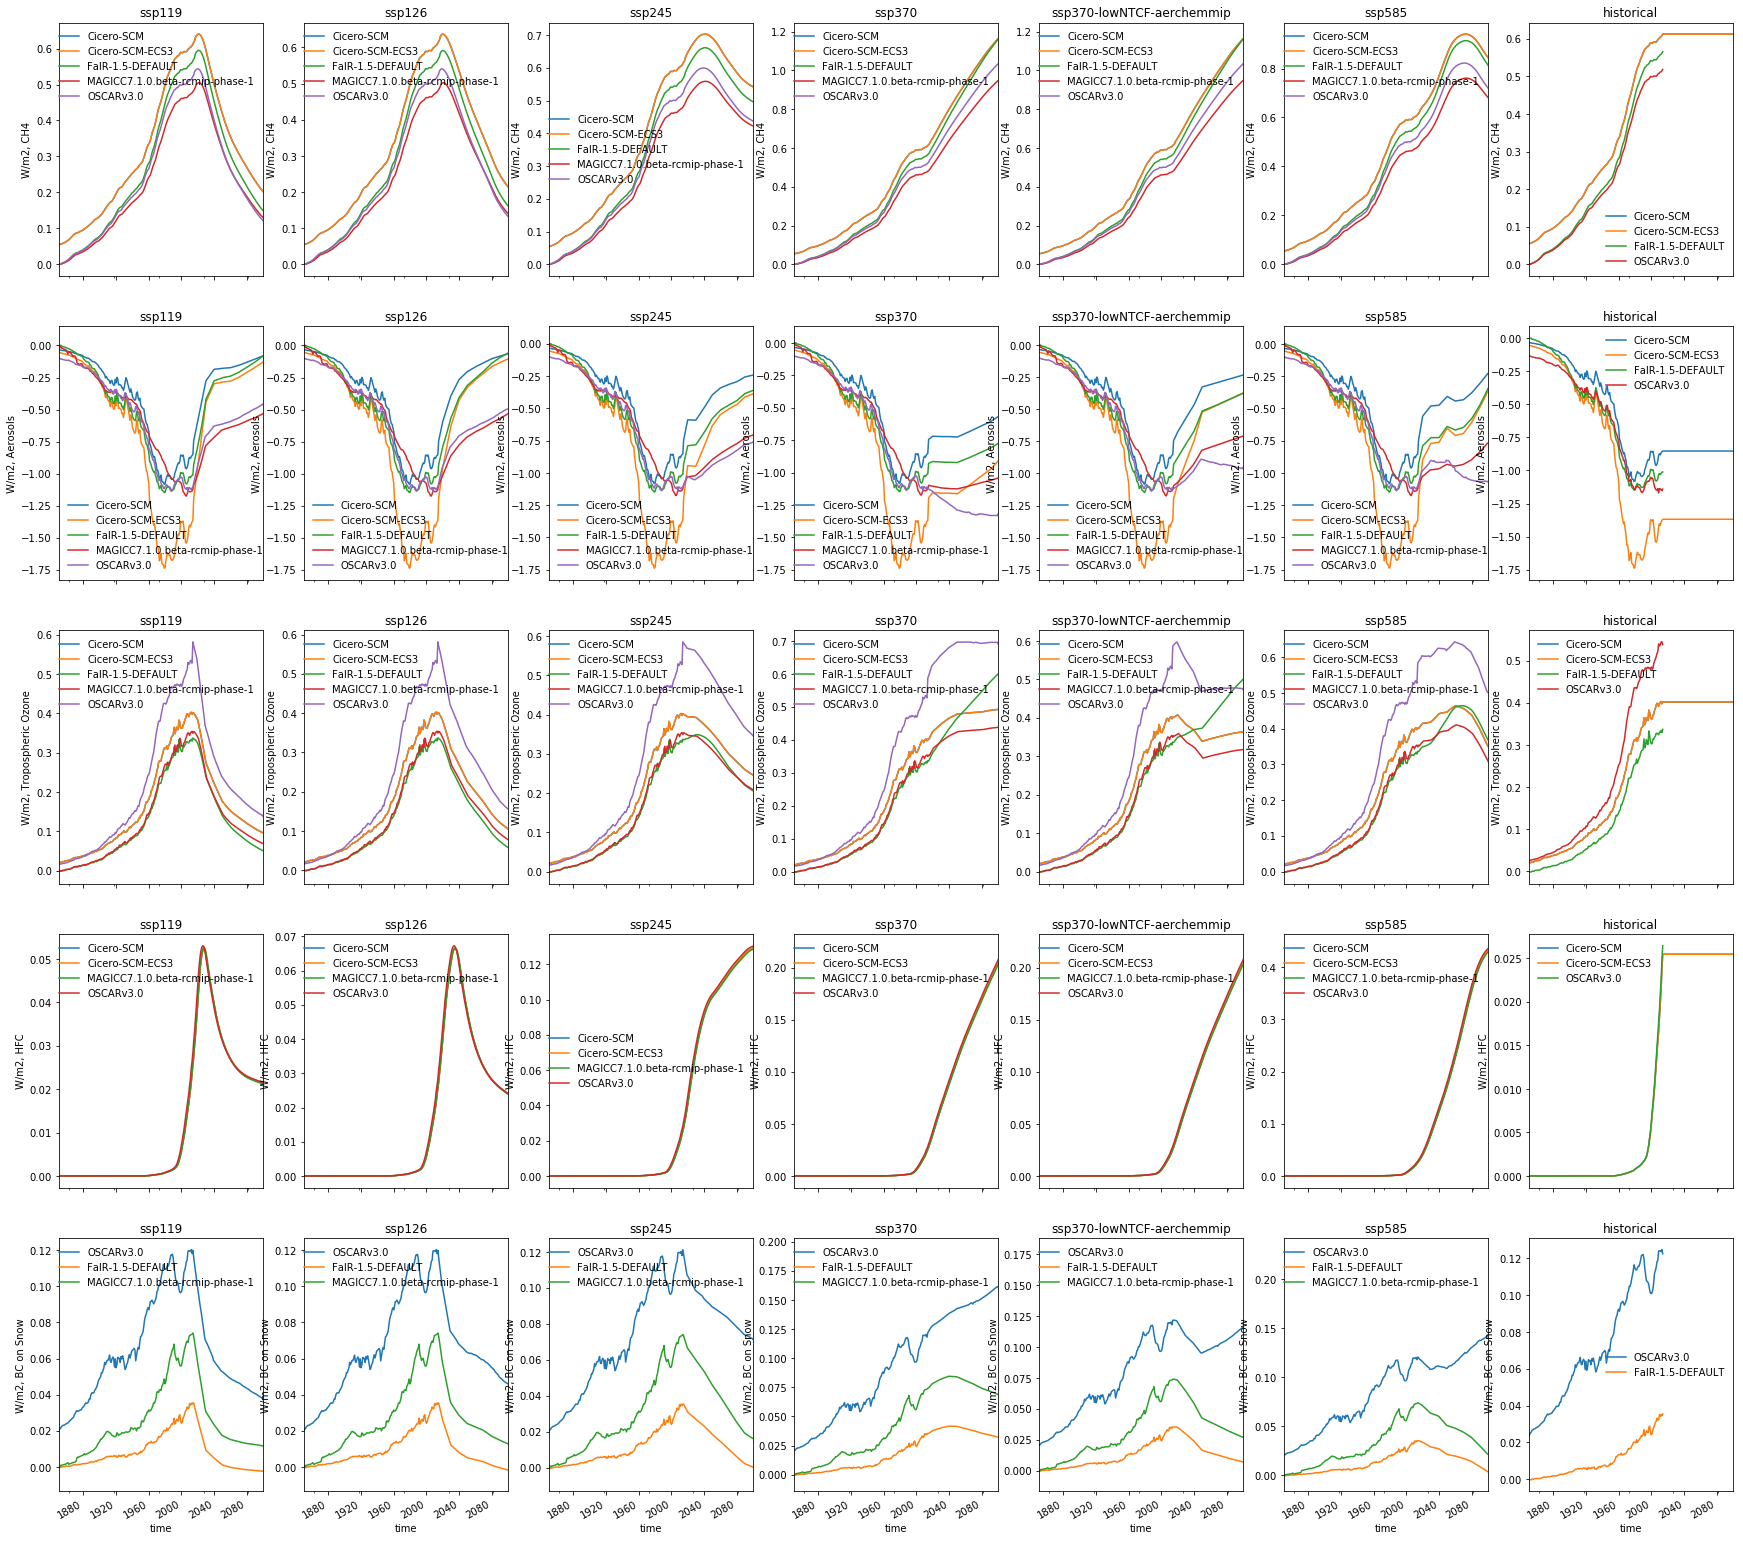

In [31]:
plot_available_out(db_converted_units, variables_erf_comp, scenarios_fl)

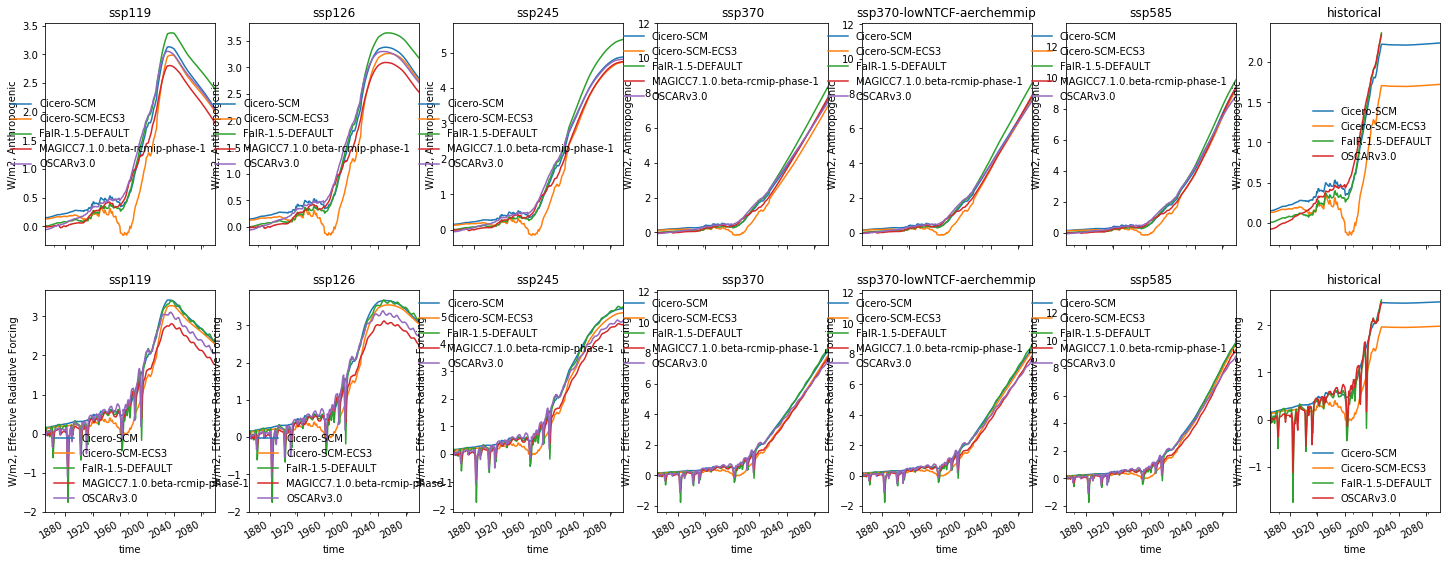

In [46]:
plot_available_out(db_converted_units, variables_erf_tot, scenarios_fl, figsize=[25,10])

### Pick out the existing scenarios, models, forcings and times

In [49]:
print('Variables erf components:', variables_erf_comp)
print()
print('Variables erf totals:', variables_erf_tot)

Variables erf components: ['Effective Radiative Forcing|Anthropogenic|CH4', 'Effective Radiative Forcing|Anthropogenic|Aerosols', 'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone', 'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC', 'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']

Variables erf totals: ['Effective Radiative Forcing|Anthropogenic', 'Effective Radiative Forcing']


In [34]:
db_converted_units = db_converted_units.filter(variable=variables_erf_comp + variables_erf_tot)

scenario = 'scenario'
climatemodel = 'climatemodel'
forcer = 'forcer'
time = 'time'
scenarios = list(db_converted_units[scenario].unique())  # scenarios_fl
climatemodels_fl = list(db_converted_units[climatemodel].unique())
forcings = list(db_converted_units[variable].unique())
times = db_converted_units.time_points  # timeseries().transpose().index

## Convert data to xarray dataset



In [50]:
import cftime

t_coord = db_converted_units.timeseries().transpose().index.values

ds = xr.Dataset()  # coords={time:t_coord, climatemodel:climatemodels_fl,
#      scenario:scenarios})
first = True
for var in variables_erf_comp + variables_erf_tot:
    # get data array for variable:
    _da = db_converted_units.filter(variable=var, climatemodel=climatemodels_fl
                                    ).timeseries().transpose().unstack().to_xarray().squeeze()
    # convert to dataset:
    _ds = _da.to_dataset(name=var)
    # remove coordinate for variabel (contained in name):
    del _ds.coords[variable]
    # merge with existing dataset:
    ds = xr.merge([_ds, ds])
ds['year'] = xr.DataArray([t.year for t in ds['time'].values], dims='time')
ds['month'] = xr.DataArray([t.month for t in ds['time'].values], dims='time')
ds['day'] = xr.DataArray([t.day for t in ds['time'].values], dims='time')
# Convert to cftime
dates = [cftime.DatetimeGregorian(y, m, d) for y, m, d in zip(ds['year'], ds['month'], ds['day'])]
ds['time'] = dates
ds = ds.sel(time=slice('1850', '2100'))
ds['time'] = pd.to_datetime([pd.datetime(y, m, d) for y, m, d in zip(ds['year'], ds['month'], ds['day'])])
# Timestep for integral:
ds['delta_t'] = xr.DataArray(np.ones(len(ds['time'])), dims='time', coords={'time': ds['time']})
ds_save = ds.copy()

In [51]:
ds


<xarray.Dataset>
Dimensions:                                                       (climatemodel: 5, scenario: 7, time: 251)
Coordinates:
  * time                                                          (time) datetime64[ns] 1850-01-01 ... 2100-01-01
    model                                                         <U1 ''
  * scenario                                                      (scenario) object 'historical' ... 'ssp585'
    region                                                        <U5 'World'
    unit                                                          <U5 'W/m^2'
  * climatemodel                                                  (climatemodel) object 'Cicero-SCM' ... 'OSCARv3.0'
    unit_context                                                  <U12 'not_required'
Data variables:
    Effective Radiative Forcing                                   (scenario, climatemodel, time) float64 0.1519 ... 8.846
    Effective Radiative Forcing|Anthropogenic                     (scenario, climatemodel, time) float64 0.1465 ... 8.808
    Effective Radiative Forcing|Anthropogenic|Other|BC on Snow    (scenario, climatemodel, time) float64 nan ... 0.143
    Effective Radiative Forcing|Anthropogenic|F-Gases|HFC         (scenario, climatemodel, time) float64 2.505e-08 ... 0.4356
    Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone  (scenario, climatemodel, time) float64 0.0222 ... 0.5016
    Effective Radiative Forcing|Anthropogenic|Aerosols            (scenario, climatemodel, time) float64 -0.03511 ... -1.069
    Effective Radiative Forcing|Anthropogenic|CH4                 (scenario, climatemodel, time) float64 0.05507 ... 0.7203
    year                                                          (time) int64 1850 ... 2100
    month                                                         (time) int64 1 ... 1
    day                                                           (time) int64 1 ... 1
    delta_t                                                       (time) float64 1.0 ... 1.0

In [52]:

ds_save.to_netcdf(SAVEPATH_DATASET)

In [53]:
SAVEPATH_DATASET

'/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGS/ar6_ch6_rcmipfigs/data_postproc/forcing_data_rcmip_models.nc'